# Bayesian calibration of polynomials using `emcee` and `rxmc`

In [1]:
from matplotlib import pyplot as plt

In [2]:
import numpy as np
from scipy import stats
import dill

In [3]:
import rxmc

Using database version X4-2024-12-31 located in: /mnt/home/beyerkyl/x4db/unpack_exfor-2024/X4-2024-12-31


In [4]:
rng = np.random.default_rng(42)

In [5]:
poly = rxmc.physical_model.Polynomial(9)

In [6]:
true_params = [1, 0.1, -0.1, -0.4, -0.11, -0.3, 0.5, -0.3, 0.3, 0.5, ]

## Generate synthetic data 

We will use 2 very percise data sets with few data and two very impercise data sets with much data

In [7]:
settings = [
    {
        "domain": [-0.4, 0.1],
        "N": 500,
        "noise": 0.1,
        "systematic_err": 0.1,
    },
    {
        "domain": [0.3, 0.6],
        "N": 300,
        "noise": 0.1,
        "systematic_err": 0.05,
    },
    {
        "domain": [-0.5, 0.2],
        "N": 25,
        "noise": 0.01,
        "systematic_err": 0.05,
    },
    {
        "domain": [-0.1, 0.6],
        "N": 15,
        "noise": 0.001,
        "systematic_err": 0.05,
    },
]

In [8]:
def generate_observations(settings, true_model, rng, true_params, scale_err=True):
    obs = []
    for setting in settings:
        x0, x1 = setting["domain"]
        synthetic_obs = rxmc.observation.Observation(
            x=rng.random(setting["N"]) * (x1 - x0) + x0,
            y=np.zeros(setting["N"]),
            y_stat_err=np.ones(setting["N"]) * setting["noise"],
            y_sys_err_normalization=setting["systematic_err"],
        )
        renormalization = rng.normal(1, setting["systematic_err"])
        y_true = true_model(synthetic_obs, *true_params)
        if scale_err:
            synthetic_obs.y = rng.normal(y_true, setting["noise"]) * renormalization
        else:
            synthetic_obs.y = rng.normal(y_true * renormalization, setting["noise"])

        synthetic_obs.renormalization = renormalization

        obs.append(synthetic_obs)
    return obs

In [9]:
observations = generate_observations(settings, poly, rng, true_params, scale_err=False)

In [10]:
N_fine = 100
domain_fine = (-1, 1)
truth = rxmc.observation.Observation(
    x=np.linspace(*domain_fine, N_fine), y=np.zeros(N_fine)
)
truth.y = poly(truth, *true_params)

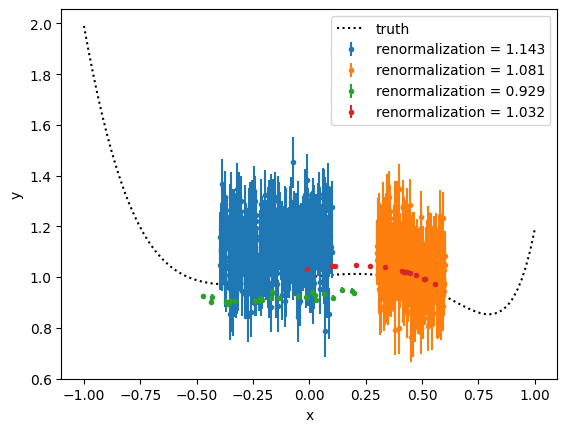

In [11]:
plt.plot(truth.x, truth.y, "k:", label="truth")
for synthetic_observation in observations:
    plt.errorbar(
        synthetic_observation.x,
        synthetic_observation.y,
        np.sqrt(np.diag(synthetic_observation.statistical_covariance)),
        linestyle="none",
        marker=".",
        label=f"renormalization = {synthetic_observation.renormalization:1.3f}",
    )
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

In [12]:
evidence_model = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            observations,
            poly,
            rxmc.likelihood_model.LikelihoodModel(),
        )
    ]
)

## Priors
We will put a tight prior on $a_0$, to avoid identifiability issues, as $a_0$ corresponds to an additive offset of the entire model, which is pretty confounding with a multiplicative bias.

In [13]:
prior_cov = np.diag(np.ones(len(poly.params)))
prior_cov[0, 0] = 0.001
prior_mean = np.zeros(len(poly.params))
prior_mean[0] = 1
model_prior = stats.multivariate_normal(mean=prior_mean, cov=prior_cov)

## Calibration config 

The `CalibrationConfig` object provides a generic interface to plug `rxmc` `Evidence` objects into thrid party samplers. 

In [14]:
from rxmc.config import CalibrationConfig, ParameterConfig

In [15]:
pconf = ParameterConfig(
    params=poly.params,
    prior=model_prior,
    initial_proposal_distribution=model_prior,
)

In [16]:
cal_conf = CalibrationConfig(
    evidence=evidence_model,
    model_config=pconf,
)

In [17]:
with open("./rxmc_poly_demo_conf.pkl", "wb") as f:
    dill.dump(cal_conf, f)